# Claire's Node: Decision Tree ONLY

In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits


In [2]:
# base classes

class Node:
    def __init__(self):
        pass 

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"): # leaf node has no 'feature' attribute
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

# Decision Tree

In [3]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack): 
            node = stack.pop()    # check the last node on the stack
            
            #print("Node >>> ", node.data.shape)
            
            n = node.data.shape[0]    # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected feature indices. 
                # This turns 'node' into a split node and returns the two children, which must be placed on the 'stack'.
                feature_indices = np.random.permutation(D)[:D_try]
                left, right = make_decision_split_node(node, feature_indices)
                if left is not None:
                    stack.append(left)
                    stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                if (node.labels.size > 0):
                    make_decision_leaf_node(node)
                
                
    def predict(self, x): # here x is single data point
        
        leaf = self.find_leaf(x)
        # compute p(y | x) --> why do we need this here???
        # posterior = np.sum(leaf.labels==leaf.response)/leaf.N

        return leaf.response #, posterior # your code here

In [4]:
def calc_gini(labels):
    "Calculate gini impurity score for a given set of labels"
    counts = np.unique(labels,return_counts=True)[1]
    gini_impurity = 1-np.square(counts / counts.sum()).sum() 
    
    return gini_impurity


def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    j_min, t_min = None, None
    
    gini_parent = calc_gini(node.labels)
    gini_min = gini_parent*n
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 'np.unique()'. 
        # Describe here why this is necessary --> this reduces the computation of looping over all training data to test all the mid-points in-between, where a lot of these pixels are of the same values
        data_unique = np.unique(node.data[:, j])
        
        # Compute candidate thresholds
        tj = ((data_unique[1:]+data_unique[:-1])/2).astype(int)
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            left_indices = np.nonzero(node.data[:, j] <= t)[0] 
            right_indices = np.nonzero(node.data[:, j] > t)[0]
            
            # Compute the gini score for children
            gini_left = calc_gini(node.labels[left_indices])
            gini_right = calc_gini(node.labels[right_indices])
            
            # choose the best threshold with minimize the sum of children's gini scores
            if gini_left*len(left_indices) + gini_right*len(right_indices) < gini_min:
                gini_min = gini_left*len(left_indices) + gini_right*len(right_indices)
                j_min = j
                t_min = t
                left_min = left_indices
                right_min = right_indices
            
    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and labels according to the optimal split found above
    left.data = node.data[left_min,:] # data in left node
    left.labels = node.labels[left_min] # corresponding labels
    right.data = node.data[right_min,:]
    right.labels = node.labels[right_min]

    # turn the current 'node' into a split node (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    



In [5]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = node.labels.size # why do we need this???
    node.response = max(set(node.labels), key=list(node.labels).count)
    posterior = max(np.unique(node.labels,return_counts=True)[1])/node.N
    # print('\tleaf_node: response={},N={},posterior={}'.format(node.response, node.N,posterior))    
    

In [6]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    assert hasattr(node, 'labels'), 'current node has no labels'
    classes = np.unique(node.labels) # returns an array of unique labels, i.e. classes 
    return len(classes) == 1 


# Evaluation of Density and Decision Tree

In [7]:
# read and prepare the digits data
# your code here

from sklearn.datasets import load_digits
digits = load_digits()
data = digits["data"]
labels = digits["target"]

print(data.shape, labels.shape)


(1797, 64) (1797,)


In [8]:
# train trees, plot training error confusion matrices, and comment on your results
# your code here

decision_tree = DecisionTree()
decision_tree.train(data, labels)

Confusion Matrix - Prediction Accuracy Training


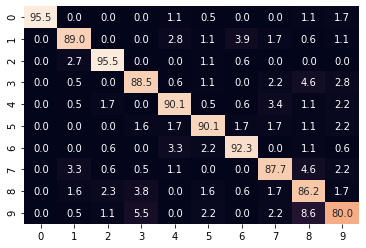

In [9]:

from sklearn.metrics import confusion_matrix

predictions = []
for x in data:
    predictions.append(decision_tree.predict(x))

rebase = np.unique(labels,return_counts=True)[1]
confusion = confusion_matrix(labels, predictions) / rebase *100

from seaborn import heatmap
heatmap(confusion,annot=True,fmt=".1f",cbar=False) 
print("Confusion Matrix - Prediction Accuracy Training")

# Density and Decision Forest

In [13]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
        self.n_trees = n_trees
    
    def train(self, data, labels, n_min=0):
        N_total = len(labels)
        N_subset = int(0.368*N_total)
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            subset_indices = np.random.permutation(N_total)[:N_subset]
            tree.train(data[subset_indices], labels[subset_indices])
            
    def predict(self, x):
        # compute the ensemble prediction
        prediction = []
        for tree in self.trees:
            prediction.append(tree.predict(x))
        
        result = max(set(prediction), key=prediction.count)
        return result # your code here

# Evaluation of Density and Decision Forest

Confusion Forest - Prediction Accuracy Training


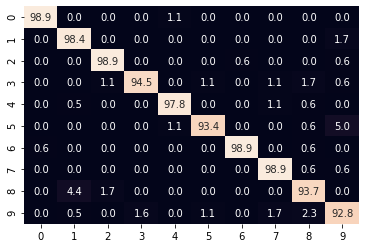

In [14]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
# your code here

decision_forest = DecisionForest(n_trees=20)

decision_forest.train(data, labels)

predictions = []
for x in data:
    predictions.append(decision_forest.predict(x))

rebase = np.unique(labels,return_counts=True)[1]
confusion_forest = confusion_matrix(labels, predictions) / rebase *100

heatmap(confusion_forest,annot=True,fmt=".1f",cbar=False) 
print("Confusion Forest - Prediction Accuracy Training")